# Aplicando ZScale e Stretch Asinh para Imagens Astronômicas com Astropy

Este notebook demonstra como replicar o **"zscale sinh" do DS9** usando **Astropy** e **Matplotlib** em Python. Vamos:

1. **Carregar** uma imagem FITS astronômica.
2. **Aplicar** o intervalo ZScale para determinar os limites de exibição.
3. **Aplicar** o stretch Asinh (seno hiperbólico) para realçar características da imagem.
4. **Exibir** a imagem processada.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ZScaleInterval, AsinhStretch, ImageNormalize
from astropy.io import fits

def find_image_hdu(hdulist):
    """
    Encontra o primeiro HDU que contém dados de imagem.
    
    Parâmetros:
        hdulist (HDUList): A lista de HDUs do arquivo FITS.
        
    Retorna:
        tuple: (Índice do HDU, Objeto HDU) se encontrado, caso contrário (None, None)
    """
    for idx, hdu in enumerate(hdulist):
        if isinstance(hdu, (fits.ImageHDU, fits.CompImageHDU)) and hdu.data is not None:
            return idx, hdu
    return None, None

In [2]:
fits_image_filename= 'dp02_02c_image_deepCoadd_tract_3831_patch_03_g_band.fits'

In [3]:
# Abrir o arquivo FITS e encontrar o HDU da imagem
with fits.open(fits_image_filename) as hdulist:
    hdu_index, image_hdu = find_image_hdu(hdulist)
    
    if hdu_index is not None:
        print(f"Dados da imagem encontrados no HDU {hdu_index} ({image_hdu.name})")
        data = image_hdu.data
    else:
        raise ValueError("Nenhum dado de imagem encontrado em qualquer HDU do arquivo FITS.")
    
    # Opcionalmente, exibir as informações do HDU novamente
    hdulist.info()

Dados da imagem encontrados no HDU 1 (IMAGE)
Filename: dp02_02c_image_deepCoadd_tract_3831_patch_03_g_band.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  IMAGE         1 PrimaryHDU      25   ()      
  1  IMAGE         1 CompImageHDU     33   (4200, 4100)   float32   
  2  MASK          1 CompImageHDU     48   (4200, 4100)   int32   
  3  VARIANCE      1 CompImageHDU     33   (4200, 4100)   float32   
  4  ARCHIVE_INDEX    1 BinTableHDU     41   14449R x 7C   [1J, 1J, 1J, 1J, 1J, 64A, 64A]   
  5  FilterLabel    1 BinTableHDU     28   1R x 3C   [2X, 32A, 32A]   
  6  SkyWcs        1 BinTableHDU     17   268R x 1C   [1QB(9304)]   
  7  CoaddInputs    1 BinTableHDU     81   65R x 16C   [1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1K, 1J, 1J, 1J, 1J, 1J, 1D, 32A]   
  8  WarpedPsf     1 BinTableHDU     25   65R x 3C   [1J, 1J, 1J]   
  9  PsfexPsf      1 BinTableHDU     52   201R x 9C   [1J, 1J, 1J, 1J, 1J, 1J, 1D, 1D, 1E]   
 10  PsfexPsf      1 BinTableHDU     45   201R x 8

In [4]:
# Verificar as dimensões dos dados
print(f"Formato dos dados: {data.shape}")
print(f"Tipo dos dados: {data.dtype}")

# Se os dados tiverem mais de 2 dimensões, selecionar o primeiro slice
if data.ndim > 2:
    print(f"Formato original dos dados: {data.shape}")
    data = data[0]  # Modificar este índice com base na estrutura dos seus dados
    print(f"Novo formato dos dados após o slicing: {data.shape}")

Formato dos dados: (4100, 4200)
Tipo dos dados: float32


### Aplicando o Intervalo ZScale

O algoritmo ZScale calcula os valores mínimos (`vmin`) e máximos (`vmax`) ótimos para exibição, melhorando o contraste ao ignorar valores atípicos extremos.

In [5]:
# Inicializar ZScaleInterval
zscale = ZScaleInterval()

# Calcular vmin e vmax usando o ZScale
vmin, vmax = zscale.get_limits(data)

print(f"ZScale vmin: {vmin}")
print(f"ZScale vmax: {vmax}")

ZScale vmin: -0.1043950617313385
ZScale vmax: 0.18369823329997867


### Aplicando o Stretch Asinh

O stretch Asinh (seno hiperbólico) é uma função de escalonamento não linear que realça características tênues e brilhantes da imagem. Ele se comporta linearmente para valores de baixa intensidade e de forma logarítmica para valores de alta intensidade.


In [6]:
# Inicializar AsinhStretch
stretch = AsinhStretch()

# Criar um objeto de normalização combinando o intervalo ZScale e o alongamento Asinh
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=stretch)

### Exibindo as Imagens

Vamos visualizar a imagem original junto com a imagem processada com ZScale e alongamento Asinh.


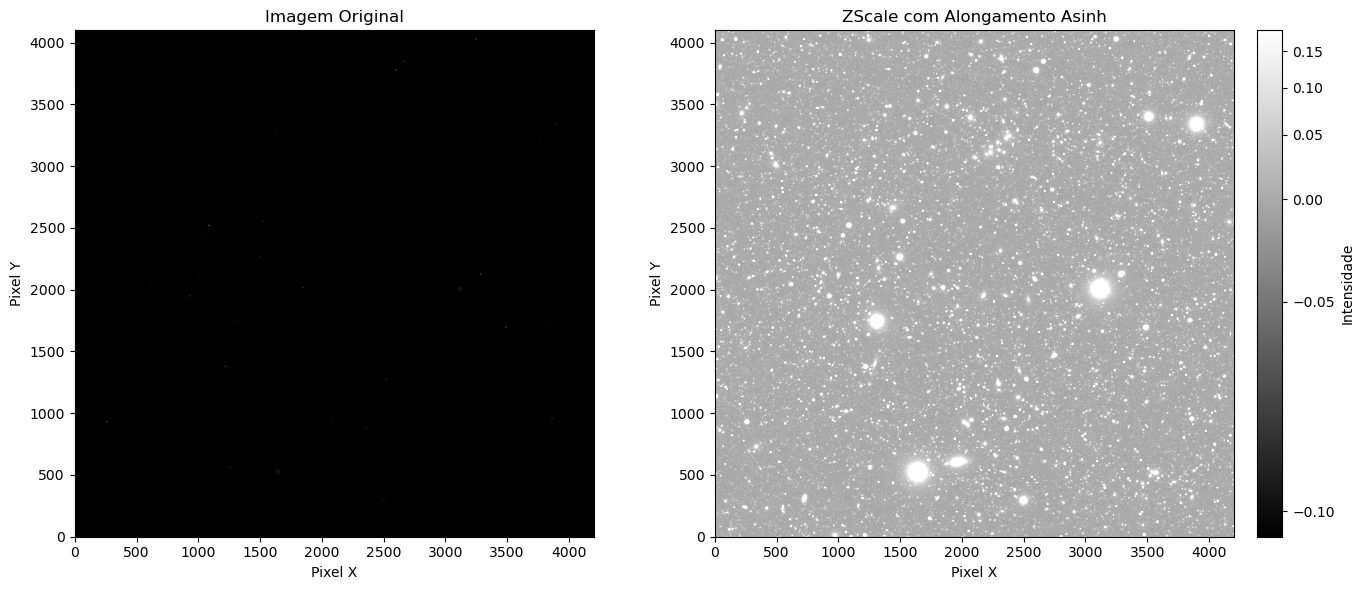

In [7]:
# Configurar o gráfico
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Imagem Original
axes[0].imshow(data, cmap='gray', origin='lower')
axes[0].set_title('Imagem Original')
axes[0].set_xlabel('Pixel X')
axes[0].set_ylabel('Pixel Y')

# Imagem Processada com ZScale e Alongamento Asinh
im = axes[1].imshow(data, cmap='gray', origin='lower', norm=norm)
axes[1].set_title('ZScale com Alongamento Asinh')
axes[1].set_xlabel('Pixel X')
axes[1].set_ylabel('Pixel Y')

# Adicionar uma barra de cores à imagem processada
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label='Intensidade')

plt.tight_layout()
plt.show()

### Personalizações Adicionais

- **Ajustando os Parâmetros do Alongamento:**
  
  Você pode modificar o parâmetro `a` do `AsinhStretch` para controlar o formato do alongamento.


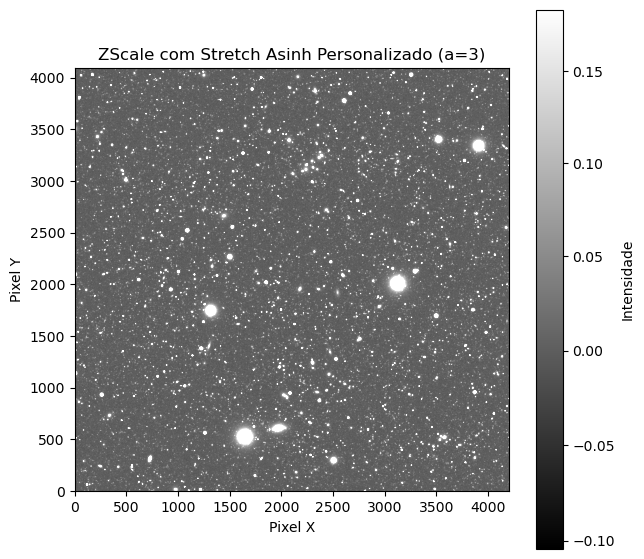

In [8]:
# Exemplo: Ajustando o parâmetro 'a' do AsinhStretch
stretch_custom = AsinhStretch(a=3)
norm_custom = ImageNormalize(vmin=vmin, vmax=vmax, stretch=stretch_custom)

# Exibir a imagem com alongamento personalizado
plt.figure(figsize=(7, 7))
plt.imshow(data, cmap='gray', origin='lower', norm=norm_custom)
plt.colorbar(label='Intensidade')
plt.title('ZScale com Stretch Asinh Personalizado (a=3)')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()